# Interictal Features

We explore the AR coefficient response to 45 mins sampled intervals of interictal data.

In [1]:
import os
import re
import mne
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ARMA import ARMA

In [391]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'
figroot = '../figures/feature_extraction/'

In [3]:
# filter out files from preictal class
regex = re.compile(r'^(chb01_03\.edf|chb01_04\.edf|chb01_15\.edf|' \
                   'chb01_16\.edf|chb01_18\.edf|chb01_26\.edf)|\.(seizures)|\.(txt)|\.(html)$')
interictal_files = [root+x for x in os.listdir(root) if not regex.search(x)]

## Visualise EEG

In [388]:
# plot parameters
plot_kwargs = {
    'scalings': dict(eeg=85e-5), # manually set scale to 500 uV for 'best' representation (25e-5)
    'show_scrollbars': False,
    'show_scalebars': False,
    'show': True
}

In [217]:
np.random.seed(42)
index = np.random.randint(len(interictal_files))
print(interictal_files[index])
raw = mne.io.read_raw_edf(input_fname=interictal_files[index], preload=False, verbose='Error')
raw_crop = raw.copy().crop(tmin=0, tmax=2700)

/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/chb01_37.edf


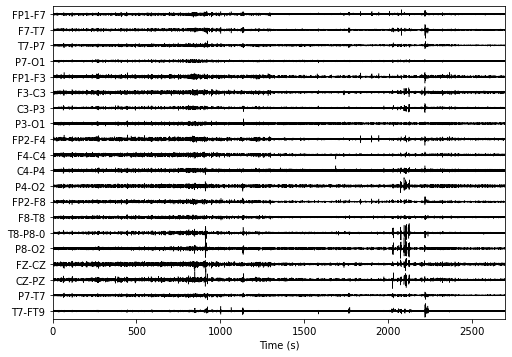

In [389]:
fig = raw_crop.plot(start=0, duration=2700, **plot_kwargs);

In [219]:
fig.savefig(figroot + 'interictal_sample_chb01_37.pdf')

## Visualise AR Response

In [220]:
# get visualised data as numpy array
EEG, times = raw_crop.get_data(picks='all', units='uV', return_times=True)
print(EEG.shape)

(23, 691201)


In [367]:
seed = 42
N = 500
p = 2
m = 30
ar = ARMA(window_width=N, order=p, memory=m, seed=seed)

In [368]:
%%time
times_ARMA, sig_AR, sig_MA = ar.spin(sig=EEG, fs=raw_crop.info['sfreq'])

100%|██████████| 690699/690699 [00:07<00:00, 97186.84it/s] 


CPU times: user 10.3 s, sys: 345 ms, total: 10.6 s
Wall time: 7.12 s


In [369]:
print(times_ARMA.shape)
print(sig_AR.shape)
print(sig_MA.shape)

(1381,)
(1381, 23, 2)
(1381, 23, 2)


In [370]:
t = np.arange(0, len(times_ARMA)) / (raw_crop.info['sfreq']/N)
ch_names = raw_crop.info['ch_names']

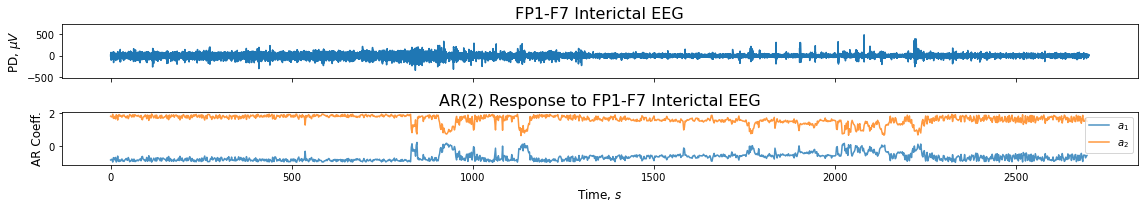

In [410]:
fig, axes = plt.subplots(figsize=(16,3), nrows=2, sharex=True)

axes[0].plot(times, EEG[0, ], label=r'$y$')
axes[0].set_title(f'{ch_names[0]} Interictal EEG', fontsize=16)
axes[0].set_ylabel(r'PD, $\mu V$', fontsize=12)
axes[0].set_ylim([EEG[0, ].min()*1.5, EEG[0, ].max()*1.5])
# axes[0].legend(loc=1)


for i in range(p):
    axes[1].plot(t, sig_AR[:,0,i], label=f'$a_{i+1}$', alpha=0.8)
axes[1].set_title(f'AR({p}) Response to {ch_names[0]} Interictal EEG', fontsize=16)
axes[1].set_xlabel('Time, $s$', fontsize=12)
axes[1].set_ylabel('AR Coeff.', fontsize=12)
axes[1].legend(loc=1)


plt.tight_layout()
plt.show()

fig.savefig(figroot + 'interictal_sample_chb01_37_AR_2_FP1_F7.pdf')

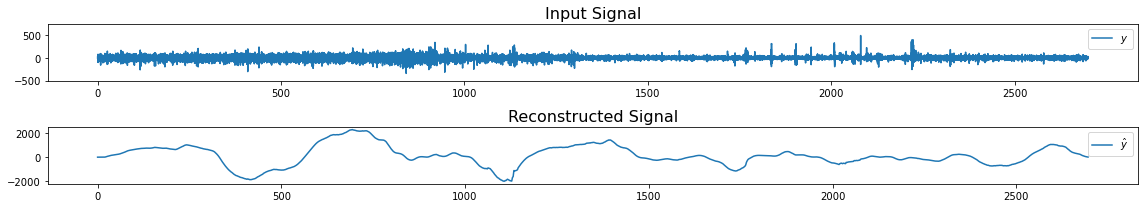

In [372]:
y_hat = np.zeros(len(t))
for i in range(p, len(t)):
    y_hat[i] = EEG[0, i]
    for j in range(p):
        y_hat[i] = y_hat[i] + sig_AR[i,0,j] * y_hat[i-1]

fig, axes = plt.subplots(figsize=(16,3), nrows=2)
axes[0].plot(times, EEG[0, ], label=r'$y$')
axes[0].set_ylim([EEG[0, ].min()*1.5, EEG[0, ].max()*1.5])
axes[0].legend(loc=1)
axes[0].set_title('Input Signal', fontsize=16) # input signal

axes[1].plot(t, y_hat, label=r'$\hat{y}$')
# axes[1].set_ylim([EEG[0, ].min()*1.5, EEG[0, ].max()*1.5])
axes[1].legend(loc=1)
axes[1].set_title('Reconstructed Signal', fontsize=16)

plt.tight_layout()
plt.show()

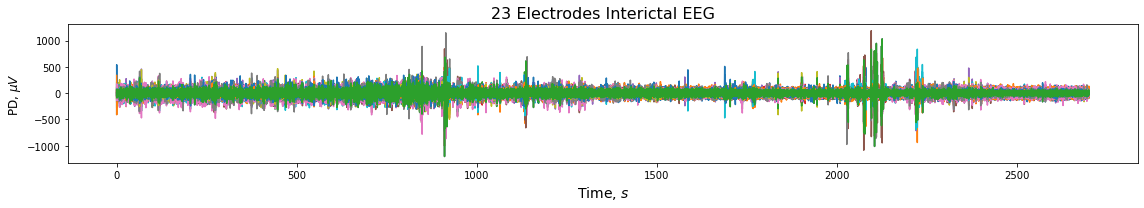

In [423]:
fig, ax = plt.subplots(figsize=(16, 3), facecolor='w', edgecolor='k')
for j in range(EEG.shape[0]): # for each channel
    ax.plot(times, EEG[j,], label=f'{ch_names[j]}')
ax.set_ylabel(r'PD, $\mu V$', fontsize=12)
ax.set_xlabel(r'Time, $s$', fontsize=14)

ax.set_title("23 Electrodes Interictal EEG".format(p), fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig(figroot + 'interictal_sample_chb01_37_EEG_all.pdf')

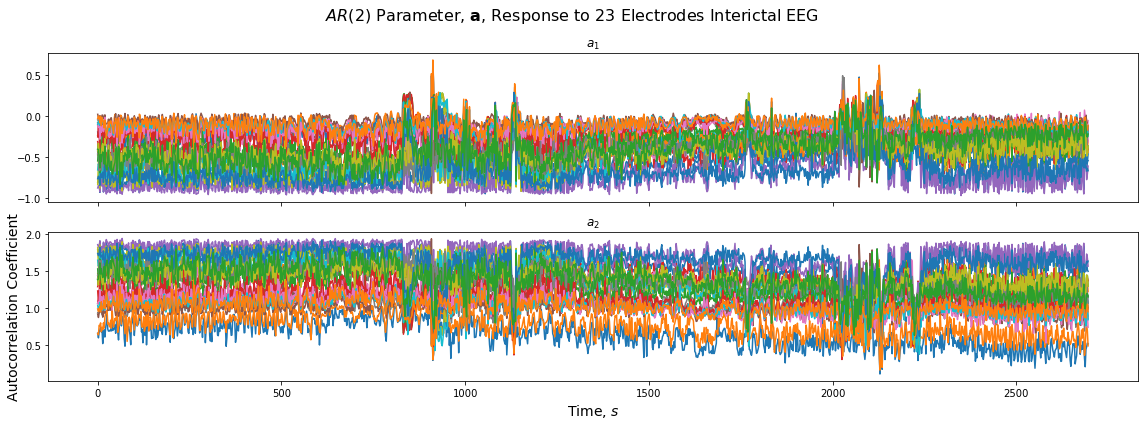

In [411]:
fig, axs = plt.subplots(p, 1, figsize=(16, 6), sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.001)
axs = axs.ravel()
for i in range(p): # for each coefficient
    for j in range(EEG.shape[0]): # for each channel
        axs[i].plot(t, sig_AR[:, j, i], label=f'{ch_names[j]}')
        axs[i].set_title(f'$a_{i+1}$')
axs[-1].set_xlabel(r'Time, $s$', fontsize=14)
axs[1].set_ylabel('Autocorrelation Coefficient', fontsize=14)
plt.suptitle(r"$AR({0})$ Parameter, $\bf{{a}}$, Response to 23 Electrodes Interictal EEG".format(p), fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig(figroot + 'interictal_sample_chb01_37_AR_2_all.pdf')

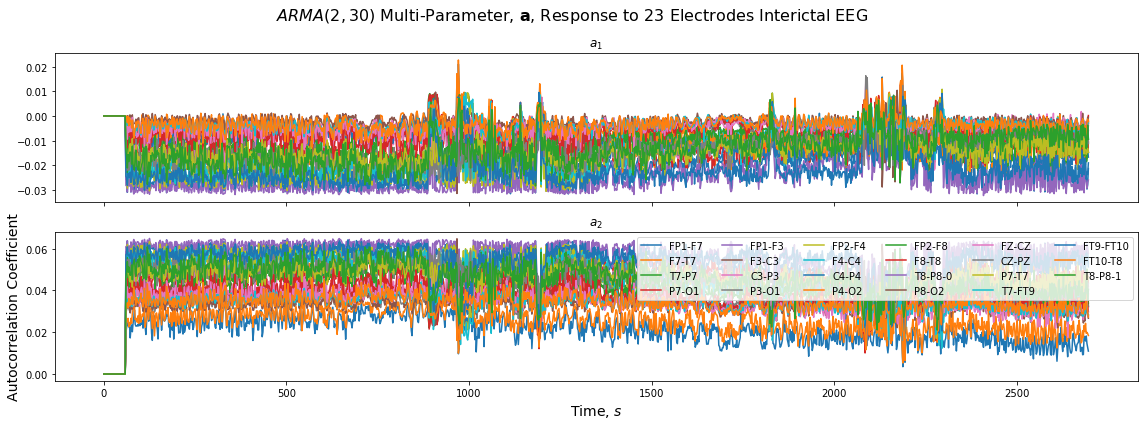

In [376]:
fig, axs = plt.subplots(p, 1, figsize=(16, 6), sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.001)
axs = axs.ravel()
for i in range(p): # for each coefficient
    for j in range(EEG.shape[0]): # for each channel
        axs[i].plot(t, sig_MA[:, j, i], label=f'{ch_names[j]}')
#         axs[i].set_ylim([-.1, .1])
        axs[i].set_title(f'$a_{i+1}$')
#         axs[i].axvline(x=seizure_start_index, color='tab:red', ls='--')
axs[-1].set_xlabel(r'Time, $s$', fontsize=14)
axs[1].set_ylabel('Autocorrelation Coefficient', fontsize=14)
# plt.legend(bbox_to_anchor=(1.12, 2.3), ncol=1)
plt.legend(loc=1, ncol=6)
plt.suptitle(r"$ARMA({0}, {1})$ Multi-Parameter, $\bf{{a}}$, Response to 23 Electrodes Interictal EEG".format(p, m), fontsize=16)
plt.tight_layout()
plt.show()  
#'ARMA{n_i, m} $\mathbf{a}$ Response to 23 Electrodes in 1 hr EEG'